In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

scan_idx = 1

start = d.sweep_start_ray_index[scan_idx].values
end = d.sweep_end_ray_index[scan_idx].values + 1

In [85]:
def centers_to_edges_1d(x):
    """
    
    This definition is used from HW#2 & HW#1
    
    """
    x_edge = x.shape[0] +1
    xe = np.empty (x_edge)
    xe [1:-1] = (x[1:] +x[:-1])/2.0
    xe [0] = x[0] - ((x[1] - x[0])/2)
    xe [-1] = x[-1] + ((x[-1] - x[-2])/2.0)
    return xe

def edges_to_centers(x):
    centers = np.empty(len(x)-1)
    width = (x[1:] - x[0:-1])/2
    centers = x[:-1] + width
    return centers

def coords_2d(data, scan_idx):
    """
    Takes an xarray data set d containing radar data and create a mesh using
    the range and elevation coordinates of the nth scan/sweep
    
    Returns the values for:
    r: range along beam (1D array)
    az: azimuthal angle (1D array)
    el: elevation angle (1D array)
    R: range mesh along beam (2D array)
    EL: elevation angle mesh (2D array)
    
    start: starting index of the nth scan
    end: ending index of the nth scan
    
    """
    # Create the edges
    
    r = centers_to_edges_1d(data.range.values)
    az = centers_to_edges_1d(data.azimuth[start:end].values)
    el = centers_to_edges_1d(d.elevation[start:end].values)
    
    #2-d grid
    
    R, AZ = np.meshgrid(r, az)
    R, EL = np.meshgrid(r, el)
    
    return R, AZ, EL


In [86]:
# range, az, el center values
r1 = d.range.values
az1 = d.azimuth[start:end].values
el1 = d.elevation[start:end].values

# Mesh Centers
r, el = np.meshgrid(r1, el1)
r, az = np.meshgrid(r1,az1)

# Edge Values
R1 = centers_to_edges_1d(r1)
AZ1 = centers_to_edges_1d(az1)
EL1 = centers_to_edges_1d(el1)

# Mesh Edges
R, AZ, EL = coords_2d(d, scan_idx)

from coordinateSystems import GeographicSystem 
from coordinateSystems import RadarCoordinateSystem
from coordinateSystems import TangentPlaneCartesianSystem

lat, lon, alt = d.latitude.values, d.longitude.values, d.altitude.values
radCoord = RadarCoordinateSystem(lat,lon,alt)
tpcs = TangentPlaneCartesianSystem(lat,lon,alt)

# ECEF centers
x,y,z = radCoord.toECEF(r, az, el)

# ECEF edges
X,Y,Z = radCoord.toECEF(R, AZ, EL)

# TCPS centers
tx, ty, tz = tpcs.fromECEF(x,y,z)

# TCPS edges
TX, TY, TZ = tpcs.fromECEF(X,Y,Z)

# Ground range and height centers
gr = np.sqrt(tx**2+ty**2)
h = tz

# Reshape 
gr.shape = r.shape
h.shape = r.shape

# Ground range and height edges
GR = np.sqrt(TX**2+TY**2)
H = TZ

# Reshape 
GR.shape = R.shape
H.shape = R.shape

ref = d.reflectivity.isel(time=slice(start,end)).values

In [87]:
# creates a boolean array where the superposition of ANY given radar data and given coordinate set 
# is located between 8900 and 9600 in range and 2800 and 3000 in altitude.

boolean_arr = np.logical_and(np.logical_and(GR>=8900, GR<=9600),np.logical_and(H>=2800, H<=3500))
boolean_arr1 = np.logical_and(np.logical_and(gr>=8900, gr<=9600),np.logical_and(h>=2800, h<=3500))

# Subset Edges
GR_sub = (GR[boolean_arr])
H_sub = (H[boolean_arr])

# Subset Centers
gr_sub = (gr[boolean_arr1])
h_sub = (h[boolean_arr1])
ref_sub = (ref[boolean_arr1])

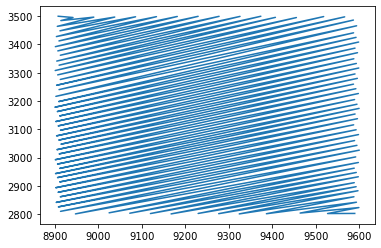

In [88]:
# Grid

# Centers
gri = np.arange(8900,9600,5)
hi = np.arange(2800,3500,5)

# Edges
GRi = centers_to_edges_1d(gri)
Hi = centers_to_edges_1d(hi)

gri, hi = np.meshgrid(gri,hi)
GRi, Hi = np.meshgrid(GRi,Hi)

centersShape = gri.shape
edgesShape = GRi.shape

#Flat centers
gri = gri.flatten()
hi = hi.flatten()

intLocs = np.array((gri,hi)).T 


#Flat edges
GRi = GRi.flatten()
Hi = Hi.flatten()

# Create array of locations
gr_sub = gr_sub.flatten()
h_sub = h_sub.flatten()
dataLocs = np.array((gr_sub,h_sub)).T #TRANSPOSE

plt.plot(gr_sub,h_sub)

In [89]:
def distance(p, q):
    """
    Linear distance between any two points is simple sqrt(p2-p1^2 +q2-q1^2).
    Its a column wise operation.
    """
    return np.sqrt(np.sum(np.square(p-q), axis=1))

p = [[4,5], [6,13], [9,16]]
q = np.ones_like(p)
print(distance(p, q))

[ 5. 13. 17.]


In [101]:
# Look for only the first sweep
start = d.sweep_start_ray_index[scan_idx].values
end = d.sweep_end_ray_index[scan_idx].values+1

dElev = d.elevation[start:end].values[1:]-d.elevation[start:end].values[:-1]

#plt.plot(dElev)

dElevMax = np.amax(dElev) # degrees
dElevMax = np.radians(dElevMax) # radians

print("Maximum spacing in elevation angle (in radians): ", dElevMax)

# Find the max range in the subset area of interest

ranges = distance(dataLocs,np.array([0,0]))
maxRange = np.amax(ranges) 
print("Maximum distance from the radar (m): ", maxRange)

# Use geometry to find the linear distance (as opposed to the arc length)
maxLinDis = maxRange*np.sin(dElevMax) 
print("Max linear distance between gates (m): ", maxLinDis/2) 

Maximum spacing in elevation angle (in radians):  0.0035473306
Maximum distance from the radar (m):  10200.623885175151
Max linear distance between gates (m):  18.09245472402059


In [91]:
from scipy.spatial import cKDTree
from functools import partial

def oban(points, values, xi, weight_func, search_radius):
    """
    points: N,2 data point locations
    values: N data values
    xi: M,2 analysis locations
    weight_func is a function that accepts a single argument r that is the
        distance between the analysis location and all points within search_radius
        of the analysis location.
    """
    
    # Find all points in the vicinity of each analysis location in xi
    tree = cKDTree(points)
    query = tree.query_ball_point(xi, search_radius)
    
    analysis = np.zeros(xi.shape[0])
    
    # This is linear (times the typical neighborhood size) in the number of analysis points
    for i, (analysis_point, neighbors) in enumerate(zip(xi, query)):
        data = values[neighbors]
        
        data_locations = points[neighbors,:]
        
        # Distances to send to the weight function
        r = distance(data_locations,xi[i])
        
        # Weights
        w = weight_func(r)

        # The ith analysis point is the weighted average of the data within the search_radius
        analysis[i] = np.sum(data*w)/np.sum(w)
        
    return analysis

def sample_weights(r, value=None):
    return np.zeros_like(r) + value

my_weight_func = partial(sample_weights, value=3.0)
my_test_ranges = np.arange(10.0)
my_test_weights = my_weight_func(my_test_ranges)

print(my_test_weights) # oban will call my_weight_func like so

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


Text(0, 0.5, 'Height Above Ground (m)')

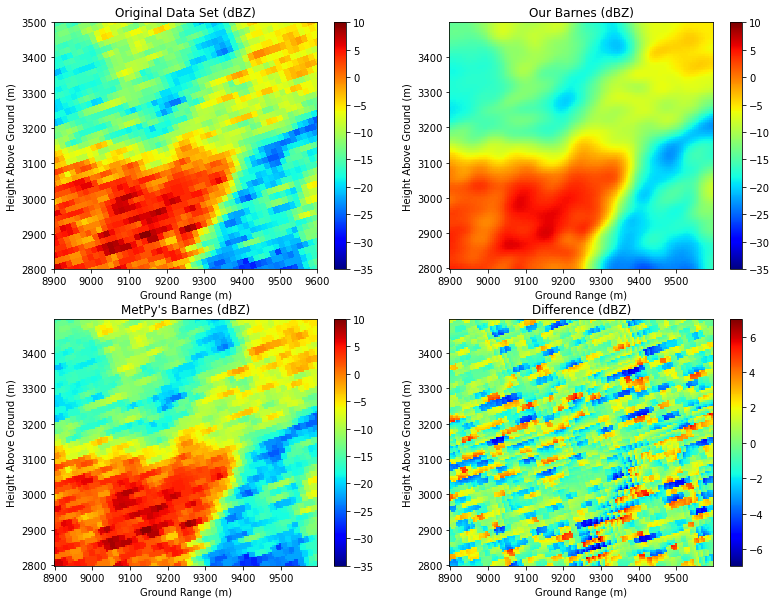

In [102]:
# Barnes function taken from HW4
def barnes(r, k=1):
    """ r has units of distance, and k is the dimensional weight parameter kappa
        kappa with units of distance squared.
        
        Returns the weights as a funcion of r.
    """
    return np.exp((-np.square(r))/k)

def kappa(kStar,Ln):
    return kStar*np.square(Ln)

# Defining our weight function with kStar = 0.5, as per the last HW
# we found that this has a lower response at the Nyquist wavelength
# than a kStar of 0.1.

kap = kappa( 0.5,maxLinDis)
b = partial(barnes, k=kap)

# We use a cutoff radius of 3*delta as found in previous HW. The weights are usually contained in about 30% of the Range.

cutOff = 3. * maxLinDis/2
intData = oban(dataLocs, ref_sub.flatten(), intLocs, b, cutOff)

from metpy.interpolate import interpolate_to_points

# Interpolate using the same kStar = .5 and search radius as above

intDataMetPy = interpolate_to_points(dataLocs, ref_sub.flatten(), intLocs,
                                     interp_type='barnes', kappa_star= 0.5,
                                     search_radius=cutOff)



GRi.shape, Hi.shape = edgesShape, edgesShape
intData.shape, intDataMetPy.shape = centersShape, centersShape

fig, axs = plt.subplots(2,2, squeeze=False, figsize=(13,10))

pcm = axs[0,0].pcolormesh(GR, H, ref, cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[0,0])
axs[0,0].set_xlim((8.9e3,9.6e3))
axs[0,0].set_ylim((2.8e3,3.5e3))
axs[0,0].set_title("Original Data Set (dBZ)")
axs[0,0].set_xlabel("Ground Range (m)")
axs[0,0].set_ylabel("Height Above Ground (m)")

pcm = axs[0,1].pcolormesh(GRi, Hi, intData,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[0,1])
axs[0,1].set_title("Our Barnes (dBZ)")
axs[0,1].set_xlabel("Ground Range (m)")
axs[0,1].set_ylabel("Height Above Ground (m)")

pcm = axs[1,0].pcolormesh(GRi, Hi, intDataMetPy,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[1,0])
axs[1,0].set_title("MetPy's Barnes (dBZ)")
axs[1,0].set_xlabel("Ground Range (m)")
axs[1,0].set_ylabel("Height Above Ground (m)")

pcm = axs[1,1].pcolormesh(GRi, Hi, (intData-intDataMetPy), cmap=plt.cm.jet)
plt.colorbar(pcm, ax=axs[1,1])
axs[1,1].set_title("Difference (dBZ)")
axs[1,1].set_xlabel("Ground Range (m)")
axs[1,1].set_ylabel("Height Above Ground (m)")

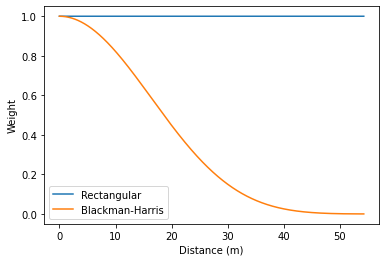

In [103]:
def rect(r,R=1):
    """
    
    Returns the value of a rectangular window at a distance r from
    the center of the window up to some cut-off radius R
    
    args:
    r -- distance from the center of the window
    R -- search radius/cut-off radius
    """
    
    return np.zeros_like(r) + 1

def blackmanHarris(r,R=1):
    """
    
    Returns the value of a Blackman-Harris window at a distance r from
    the center of the window up to some cut-off radius R
    
    args:
    r -- distance from the center of the window
    R -- search radius/cut-off radius
    """
    
    R = 2*R
    r = r+R/2
    
    return 0.35875-0.48829*np.cos(2*np.pi*r/R)+0.14128*np.cos(2*np.pi*2*r/R)-0.01168*np.cos(2*np.pi*3*r/R)

test = np.arange(0,cutOff,.01)

rc = partial(rect,R=cutOff)
bmh = partial(blackmanHarris,R=cutOff)


plt.plot(test,rc(test))
plt.plot(test,bmh(test))

plt.xlabel('Distance (m)')
plt.ylabel('Weight')
plt.legend(['Rectangular','Blackman-Harris'])

<span class="ecb">Rect window doesn't ever cut off.  -2.</span>

Text(0, 0.5, 'Height Above Ground (m)')

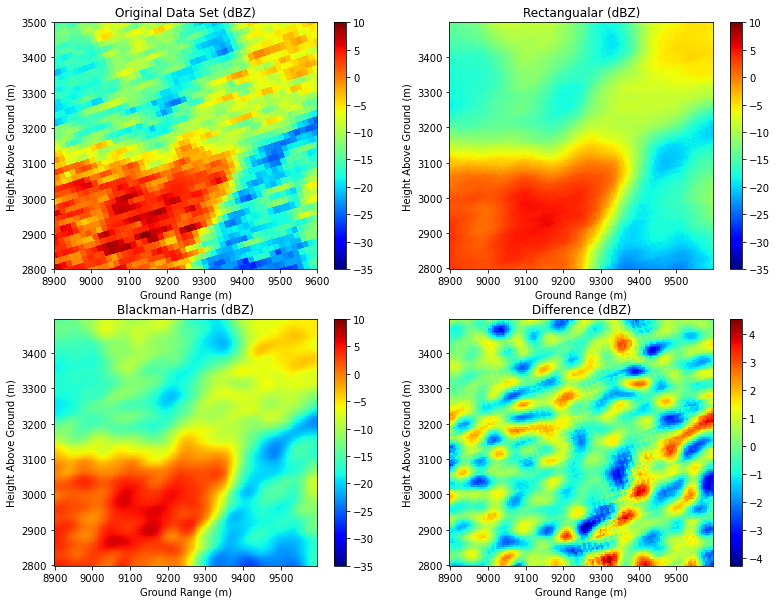

In [104]:
intDataR = oban(dataLocs, ref_sub.flatten(), intLocs, rc, cutOff)
intDataBH = oban(dataLocs, ref_sub.flatten(), intLocs, bmh, cutOff)
intDataR.shape, intDataBH.shape = centersShape, centersShape
bmDiff = intDataR-intDataBH

fig, axs = plt.subplots(2,2, squeeze=False, figsize=(13,10))

pcm = axs[0,0].pcolormesh(GR, H, ref,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[0,0])
axs[0,0].set_xlim((8.9e3,9.6e3))
axs[0,0].set_ylim((2.8e3,3.5e3))
axs[0,0].set_title("Original Data Set (dBZ)")
axs[0,0].set_xlabel("Ground Range (m)")
axs[0,0].set_ylabel("Height Above Ground (m)")

pcm = axs[0,1].pcolormesh(GRi, Hi, intDataR,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[0,1])
axs[0,1].set_title("Rectangualar (dBZ)")
axs[0,1].set_xlabel("Ground Range (m)")
axs[0,1].set_ylabel("Height Above Ground (m)")

pcm = axs[1,0].pcolormesh(GRi, Hi, intDataBH,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[1,0])
axs[1,0].set_title("Blackman-Harris (dBZ)")
axs[1,0].set_xlabel("Ground Range (m)")
axs[1,0].set_ylabel("Height Above Ground (m)")

pcm = axs[1,1].pcolormesh(GRi, Hi, bmDiff, cmap=plt.cm.jet)
plt.colorbar(pcm, ax=axs[1,1])
axs[1,1].set_title("Difference (dBZ)")
axs[1,1].set_xlabel("Ground Range (m)")
axs[1,1].set_ylabel("Height Above Ground (m)")

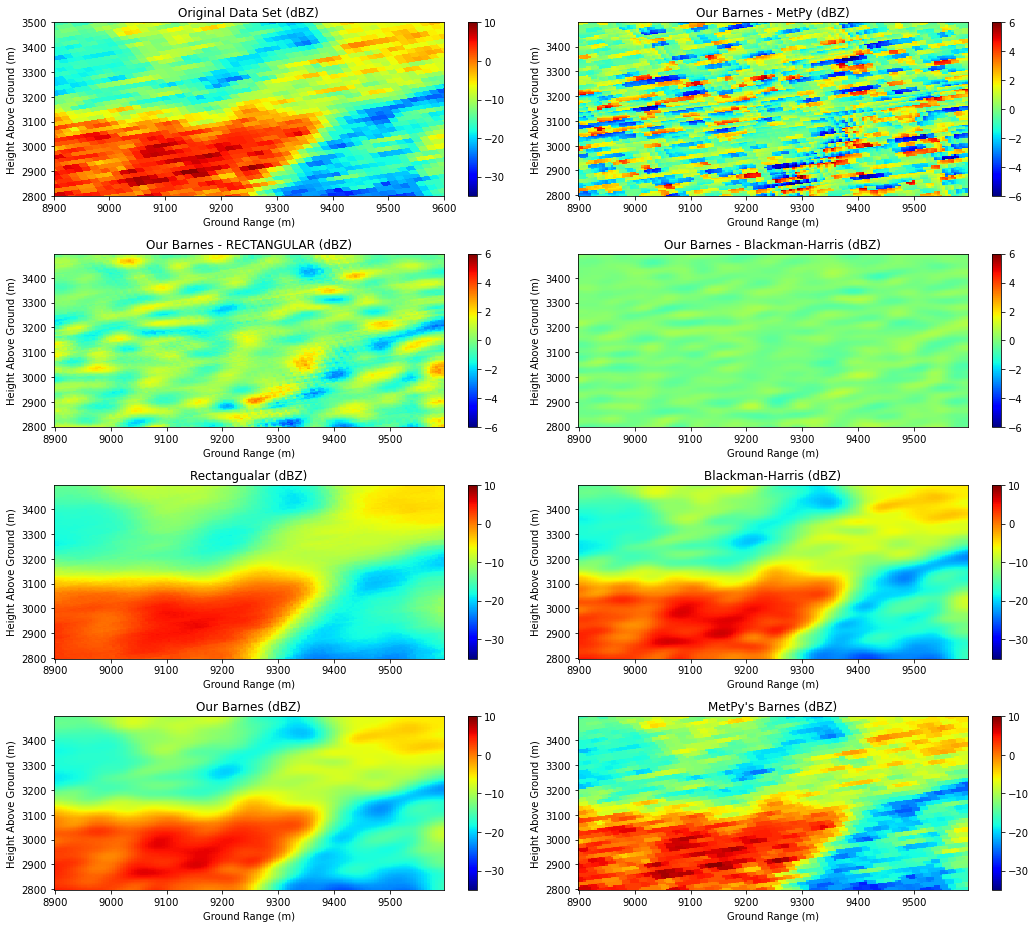

In [105]:
fig, axs = plt.subplots(4,2, squeeze=True, figsize=(15,13))

pcm = axs[0,0].pcolormesh(GR, H, ref,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[0,0])
axs[0,0].set_xlim((8.9e3,9.6e3))
axs[0,0].set_ylim((2.8e3,3.5e3))
axs[0,0].set_title("Original Data Set (dBZ)")
axs[0,0].set_xlabel("Ground Range (m)")
axs[0,0].set_ylabel("Height Above Ground (m)")

pcm = axs[0,1].pcolormesh(GRi, Hi, (intData-intDataMetPy),cmap=plt.cm.jet, vmin=-6,vmax=6)
plt.colorbar(pcm, ax=axs[0,1])
axs[0,1].set_title("Our Barnes - MetPy (dBZ)")
axs[0,1].set_xlabel("Ground Range (m)")
axs[0,1].set_ylabel("Height Above Ground (m)")

pcm = axs[1,0].pcolormesh(GRi, Hi, (intData-intDataR),cmap=plt.cm.jet, vmin=-6,vmax=6)
plt.colorbar(pcm, ax=axs[1,0])
axs[1,0].set_title("Our Barnes - RECTANGULAR (dBZ)")
axs[1,0].set_xlabel("Ground Range (m)")
axs[1,0].set_ylabel("Height Above Ground (m)")

pcm = axs[1,1].pcolormesh(GRi, Hi, (intData-intDataBH), cmap=plt.cm.jet, vmin=-6,vmax=6)
plt.colorbar(pcm, ax=axs[1,1])
axs[1,1].set_title("Our Barnes - Blackman-Harris (dBZ)")
axs[1,1].set_xlabel("Ground Range (m)")
axs[1,1].set_ylabel("Height Above Ground (m)")

pcm = axs[2,0].pcolormesh(GRi, Hi, intDataR,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[2,0])
axs[2,0].set_title("Rectangualar (dBZ)")
axs[2,0].set_xlabel("Ground Range (m)")
axs[2,0].set_ylabel("Height Above Ground (m)")

pcm = axs[2,1].pcolormesh(GRi, Hi, intDataBH,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[2,1])
axs[2,1].set_title("Blackman-Harris (dBZ)")
axs[2,1].set_xlabel("Ground Range (m)")
axs[2,1].set_ylabel("Height Above Ground (m)")

pcm = axs[3,0].pcolormesh(GRi, Hi, intData,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm1, ax=axs[3,0])
axs[3,0].set_title("Our Barnes (dBZ)")
axs[3,0].set_xlabel("Ground Range (m)")
axs[3,0].set_ylabel("Height Above Ground (m)")

pcm = axs[3,1].pcolormesh(GRi, Hi, intDataMetPy,cmap=plt.cm.jet, vmin=-35,vmax=10)
plt.colorbar(pcm, ax=axs[3,1])
axs[3,1].set_title("MetPy's Barnes (dBZ)")
axs[3,1].set_xlabel("Ground Range (m)")
axs[3,1].set_ylabel("Height Above Ground (m)")

fig.tight_layout()

